# Practice session (6)
Kindly make a copy(**File-> Save a copy in Drive**) of this notebook and rename it (xAutoML_2022_fANOVA_firstname_lastname.ipynb).

# Session objectives




*   Using fANOVA to discover the significant hyperparameters.
*   Applying KDE to find the best default value.



# Setup

In [1]:
# Please install fanova  and Configsace and then restart the run time(Runtime)
# If you want to understand more about this framework, please visit: https://automl.github.io/fanova/
!pip install fanova

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.9 MB/s eta 0:00:00
  Created wheel for fanova: filename=fanova-2.0.19-py3-none-any.whl size=12220 sha256=a2d1297ead3fd592db69fd7332ea36fe20256b9e9ad29ed1d995ca9a9d39792c
  Stored in directory: /root/.cache/pip/wheels/5e/ae/29/5078104324947fa667508d3c447a99f2784704927d141d46bd
Successfully built fanova


In [2]:
# we will use Configspace to construct a search space for each hyperparameter.
!pip install ConfigSpace

In [3]:
# importing the core packages :)
import pandas as pd
import numpy as np
from scipy import stats
import time
from statistics import median
import os
import pickle
import scipy.stats

# fANOVA & configspace
import ConfigSpace
import ConfigSpace.hyperparameters as csh
import fanova

# preprocessing
from sklearn.preprocessing import LabelEncoder

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm



#
from collections import defaultdict
from typing import List, Tuple, Dict
import collections
import copy
import json

# for ignoring the warnings massages.
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# List of homeworks
During today's practice, we will study the importance of hyperparameter for the Gradian Boosting classifier. Further, we will study the best hyperparameter values that could be used as defaults for each hyperparameter.

As homework, We want you to do the same for the Extra Trees classifier. You can find the performance runs file in the moodle(under related assignment). In particular,

1. you should study its hyperparameter's importance and plot the exact violin figure. (3 points)

2. you need to report the default value for at least one hyperparameter after fitting KDE. (3 points)

**P.S: for some of the above tasks, you may need to add more cells. please Add all extra cells at the end of the notebook. It is also acceptable to simply replace and change the command on the current cells.**



# What is fANOVA?  
The [functional ANOVA framework](https://automl.github.io/fanova/) is an efficient technique for assessing the importance of hyperparameters of a machine learning algorithm based on the computations of marginal performance. More specifically, Functional ANOVA specifies the contribution of each hyperparameter to the variance of the machine learning algorithm performance.


# Apply fANOVA in practice

## Data collection
Assume you have already conducted multiple experiments on various datasets using different ML algorithm configurations on top of a popular automl framework such as SmartML, TPOT, or Auto-sklearn. So you've gotten all of the meta-data for each ML algorithm in that automl engine. You now want to understand how to use that meta-data as extra info(meta-learning) for your AutoML tools. Therefore, we ask you to download a metadata file from Google Drive, which contains the results of the Gradient Boosting classifier over several datasets with variant configurations.




In [4]:
# Import algorithm_runs file
df_et = pd.read_csv('./ET_results_total.csv',index_col=False)
df_et.head()

,dataset,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split,n_estimators,imputation,Mean_Train_time,Std_Train_time,...,CV_f1_score,CV_recall,CV_precision,CV_auc,Std_accuracy_train,Std_accuracy,Std_f1_score,Std_recall,Std_precision,Std_auc
0,AP_Breast_Prostate.csv,True,gini,0.720759,7,5,100,NaN,3.675344,0.335697,...,0.967949,0.942857,1.0,0.971429,0.001614,0.015847,0.054166,0.094761,0.0,0.047380
1,AP_Breast_Prostate.csv,False,gini,0.183410,13,4,100,NaN,1.736630,0.091211,...,0.967949,0.942857,1.0,0.971429,0.001077,0.016127,0.054166,0.094761,0.0,0.047380
2,AP_Breast_Prostate.csv,True,entropy,0.163159,2,2,100,NaN,1.229983,0.082230,...,0.976923,0.957143,1.0,0.978571,0.001318,0.011089,0.035251,0.065465,0.0,0.032733
3,AP_Breast_Prostate.csv,True,entropy,0.750977,2,10,100,NaN,4.154286,0.197194,...,0.976923,0.957143,1.0,0.978571,0.001613,0.011001,0.035251,0.065465,0.0,0.032733
4,AP_Breast_Prostate.csv,False,gini,0.418380,8,17,100,NaN,6.452222,1.559830,...,0.967832,0.940476,1.0,0.970238,0.001077,0.011955,0.039583,0.073193,0.0,0.036596


## EDA

In [7]:
# number of datasets in this meta data file
len(df_et.dataset.unique())

# columns of the dataframe
print(df_et.columns)

Index(['dataset', 'bootstrap', 'criterion', 'max_features', 'min_samples_leaf',
       'min_samples_split', 'n_estimators', 'imputation', 'Mean_Train_time',
       'Std_Train_time', 'Mean_Test_time', 'Std_Test_time',
       'CV_accuracy_train', 'CV_accuracy', 'CV_f1_score', 'CV_recall',
       'CV_precision', 'CV_auc', 'Std_accuracy_train', 'Std_accuracy',
       'Std_f1_score', 'Std_recall', 'Std_precision', 'Std_auc'],
      dtype='object')


In [13]:
import pandas as pd
import numpy as np
import time
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from fanova import fANOVA
from sklearn.preprocessing import LabelEncoder

# Define the configuration space for ExtraTrees Classifier
def cs_et():
    cs = CS.ConfigurationSpace()

    bootstrap = CSH.CategoricalHyperparameter('bootstrap', choices=[True, False])
    criterion = CSH.CategoricalHyperparameter('criterion', choices=['gini', 'entropy'])
    max_features = CSH.UniformFloatHyperparameter('max_features', lower=0.1, upper=1.0)
    min_samples_leaf = CSH.UniformIntegerHyperparameter('min_samples_leaf', lower=1, upper=20)
    min_samples_split = CSH.UniformIntegerHyperparameter('min_samples_split', lower=2, upper=20)
    n_estimators = CSH.UniformIntegerHyperparameter('n_estimators', lower=10, upper=500)

    cs.add_hyperparameters([bootstrap, criterion, max_features, min_samples_leaf, min_samples_split, n_estimators])

    return cs

# Update the column names based on the 'df_et' dataframe
ET_cols = ['dataset', 'bootstrap', 'criterion', 'max_features', 'min_samples_leaf',
           'min_samples_split', 'n_estimators', 'CV_auc']  # Add or remove columns as needed

# Update the dictionary containing the configuration space
config_space = {
    'ExtraTrees': cs_et(),
}

# Update the dictionary containing the column names
col_names = {
    'ExtraTrees': ET_cols,
}

# Main function to run fANOVA
def do_fanova(dataset_name, algorithm, st=0, end=198):
    data = pd.read_csv(dataset_name, low_memory=False)

    # define the config space
    cs = config_space[algorithm]  # Only one config space is returned
    cols = col_names[algorithm]

    data = data.loc[:, cols]
    data = label_encoding(data, algorithm)
    datasets = data.dataset.unique()[st:end]
    results = pd.DataFrame()

    for indx, d_name in enumerate(datasets):
        print('Dataset {}({})'.format(indx + 1, d_name))
        selected = data.dataset == d_name
        data_filter = data.loc[selected, :]

        try:
            df, time_taken = fanova_to_df(data_filter, algorithm, cs)

            df['dataset'] = d_name
            df['time_taken'] = time_taken

            results = pd.concat([results, df], axis=0)
            results.to_csv('{}_fANOVA_results.csv'.format(algorithm),
                           header=True,
                           index=False)
        except Exception as e:
            print('***'
                  'The following error occurred for {} dataset:{}'
                  '***'.format(d_name, e))

# Adjusted function signature and body
def fanova_to_df(data, algorithm, cs):
    X = data.loc[:, sorted(data.columns[1:-1])].values  # Adjusted to exclude non-existing 'imputation' column
    y = data.iloc[:, -1].values

    f = fANOVA(X, y, config_space=cs)

    start = time.perf_counter()
    print('Singles')
    imp1 = get_single_importance(f)
    print('Pairs')
    imp2 = f.get_most_important_pairwise_marginals()
    print('Triples')
    imp3 = get_triple_importance(f, algorithm)

    imp = dict_merge(imp1, imp2, imp3)
    end = time.perf_counter()

    time_taken = end - start
    print('time taken is {} min'.format(time_taken / 60))

    df = pd.DataFrame({'param': list(imp.keys()),
                       'importance': list(imp.values())},
                      index=None)
    return df, time_taken

def label_encoding(data, algorithm):
    """
    Performing label encoding for the categorical hyperparameters
    of the given algorithm

    Input:
           data - (DataFrame) contains the performance data
           algorithm - (str) takes one of the following options
                        {GradientBoosting}
    Output:
           data - (DataFrame) contains only numerical features

    """
    le = LabelEncoder()

    if algorithm == 'ExtraTrees':
        # Removed the 'imputation' attribute as it doesn't exist in your DataFrame
        if 'criterion' in data.columns:
            data['criterion'] = le.fit_transform(data['criterion'])

    return data


def get_single_importance(f):
    """
    Derive importance of each hyperparameter

    Input:
           f - (fANOVA) object
    Output:
           imp1 - (dict) key: hyperparameter name
                         value: variance contribution

    """
    names = f.cs.get_hyperparameter_names()

    imp1 = {}
    for name in names:
        imp1_ind = f.quantify_importance([name])
        value = imp1_ind[(name,)]['individual importance']
        imp = {name: value}
        imp1.update(imp)

    return imp1


def get_importance(f, *params):
    """
    Derive importance of the specified
    combination of hyperparameters
    Input:
           f - (fANOVA) object
           *params - (str) names of hyperparameters
    Output:
           imp - (dict) key: hyperparameter combination
                         value: variance contribution

    """
    imp = f.quantify_importance(list(params))
    value = imp[params]['individual importance']
    imp = {params: value}
    return imp


def dict_merge(*args):
    """
    Merges several python dictionaries

    Input:
           *args - (dict) python dictionaries
    Output:
           imp - (dict) merged dictionary

    """
    imp = {}
    for dictt in args:
        imp.update(dictt)
    return imp


def get_triple_importance(f, algorithm):
    """
    Derive importance of specified triple combinations
    of hyperparameters per algorithm

    Input:
           f - (fANOVA) object
           algorithm - (str) takes one of the following options
                        {RandomForest, AdaBoost, ExtraTrees,
                         SVM, GradientBoosting}
    Output:
           imp - (dict) key: hyperparameter name
                        value: variance contribution

    """
    if algorithm == 'ExtraTrees':
        imp = get_importance(f, 'criterion',
                             'max_features', 'min_samples_leaf')

    return imp


def get_triple_impute(f, algorithm):
    """
    Derive importance of specified triple combinations
    of hyperparameters per algorithm in case of
    data imputation

    Input:
           f - (fANOVA) object
           algorithm - (str) takes one of the following options
                        {RandomForest, AdaBoost, ExtraTrees,
                         SVM, GradientBoosting}
    Output:
           imp - (dict) key: hyperparameter name
                        value: variance contribution

    """
    if np.isin(algorithm, [ 'ExtraTrees']):
        imp = get_importance(f, 'imputation',
                             'max_features', 'min_samples_leaf')

    return imp

# Now, you can call your main function with the updated parameters
do_fanova(dataset_name="./ET_results_total.csv", algorithm="ExtraTrees", st=0, end=5)  # Update the dataset_name and range as needed


Dataset 1(AP_Breast_Prostate.csv)
Singles
Pairs
Triples


time taken is 0.3444034726999992 min
Dataset 2(AP_Breast_Omentum.csv)
Singles
Pairs
Triples


time taken is 0.8554812201499999 min
Dataset 3(phpGUrE90.csv)
Singles
Pairs
Triples


time taken is 0.726016410983334 min
Dataset 4(dataset_187_abalone.csv)
Singles
Pairs
Triples


time taken is 0.6176057577333267 min
Dataset 5(dataset_31_credit-g.csv)
Singles
Pairs
Triples
time taken is 0.6955041789666666 min


## Run fANOVA

## Marginal contribution

In [19]:
df=pd.read_csv("./ExtraTrees_fANOVA_results.csv")
df.sample(30)

,param,importance,dataset,time_taken
44,"('max_features', 'min_samples_split')",7.114544e-03,phpGUrE90.csv,43.560985
9,"('criterion', 'max_features')",2.914329e-02,AP_Breast_Prostate.csv,20.664208
40,"('max_features', 'min_samples_leaf')",1.502040e-01,phpGUrE90.csv,43.560985
6,"('max_features', 'min_samples_leaf')",1.293123e-01,AP_Breast_Prostate.csv,20.664208
5,n_estimators,1.678061e-12,AP_Breast_Prostate.csv,20.664208
60,"('bootstrap', 'min_samples_leaf')",9.222781e-03,dataset_187_abalone.csv,37.056345
72,min_samples_split,4.545807e-03,dataset_31_credit-g.csv,41.730251
83,"('bootstrap', 'criterion')",3.299037e-04,dataset_31_credit-g.csv,41.730251
58,"('min_samples_leaf', 'min_samples_split')",6.446095e-02,dataset_187_abalone.csv,37.056345
1,criterion,1.017996e-02,AP_Breast_Prostate.csv,20.664208


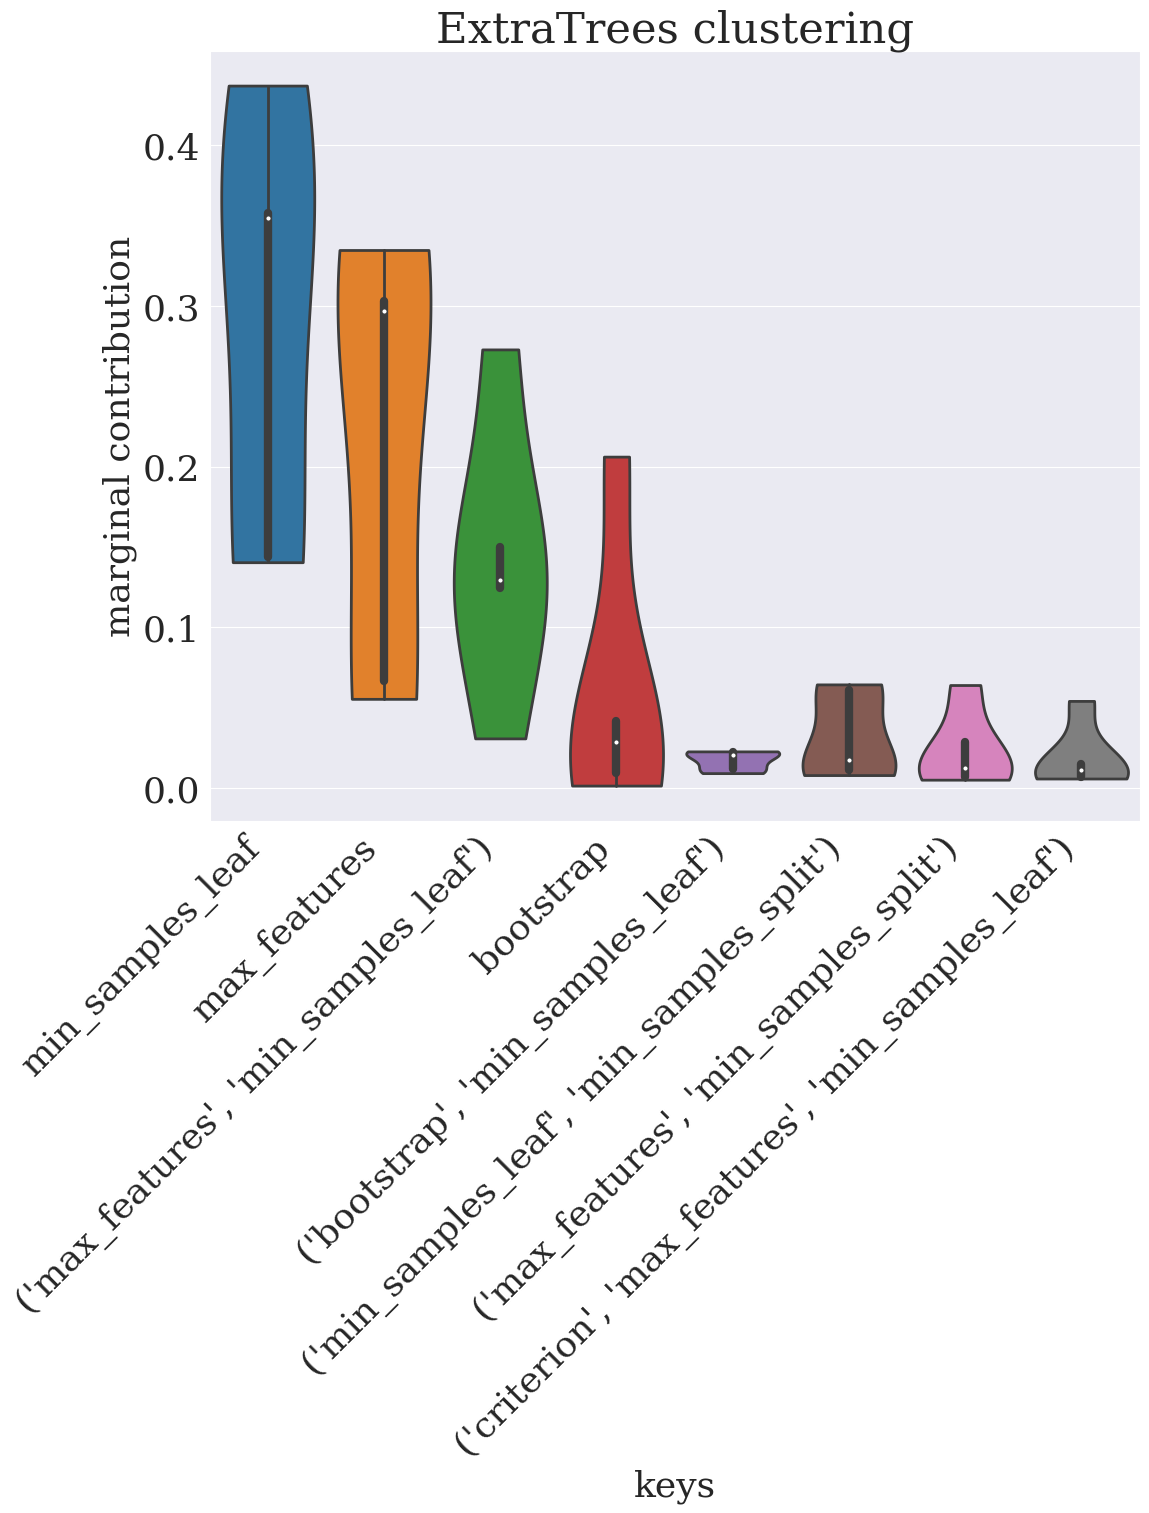

Plot displayed. Finished!


0

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import collections
import copy
import warnings
# Importing matplotlib's font manager to handle font settings
import matplotlib.font_manager as fm

def rank_dict(dictionary, reverse=False):
    '''
    Get a dictionary and return a rank dictionary
    for example dic={'a':10,'b':2,'c':6}
    will return dic={'a':1.0,'b':3.0,'c':2.0}

    '''
    dictionary = copy.copy(dictionary)

    if reverse:

        for key in dictionary.keys():
            dictionary[key] = 1 - dictionary[key]

    sortdict = collections.OrderedDict(sorted(dictionary.items()))
    ranks = scipy.stats.rankdata(list(sortdict.values()))
    result = {}

    for idx, (key, value) in enumerate(sortdict.items()):
        result[key] = ranks[idx]

    return result


def sum_dict_values(a, b, allow_subsets=False):
    '''
    Get two dictionary sum them together!
    '''
    result = {}
    a_total = sum(a.values())
    b_total = sum(b.values())
    a_min_b = set(a.keys()) - set(b.keys())
    b_min_a = set(b.keys()) - set(a.keys())

    for idx in a.keys():
        if idx in b:
            result[idx] = a[idx] + b[idx]
        else:
            result[idx] = a[idx]

    return result

def obtain_marginal_contributions(df):
    '''
    This is the main function that calls Top functions
    '''
    all_ranks = dict()
    all_tasks = list()
    total_ranks = None
    num_tasks = 0
    marginal_contribution = collections.defaultdict(list)

    lst_datasets=list(df.dataset.unique())

    for dataset in lst_datasets:


        a=df[df.dataset==dataset]
        a=a.drop("dataset",axis=1)
        param=dict()

        for index, row in a.iterrows():
            marginal_contribution[row["param"]].append(row["importance"])
            param.update( {row["param"] : row["importance"]} )

        ranks = rank_dict(param, reverse=True)
        if total_ranks is None:
            total_ranks = ranks
        else:
            total_ranks = sum_dict_values( ranks,total_ranks, allow_subsets=False)
            num_tasks += 1
    total_ranks = divide_dict_values(total_ranks, num_tasks)
    return total_ranks, marginal_contribution, lst_datasets

def marginal_plots(sorted_values, keys, fig_title):
    sns.set_style("darkgrid")

    font = {
        'family' : 'serif',
        'size'   : 26
    }

    plt.rc('font', **font)  # Using plt.rc instead of matplotlib.rc
    # fm._rebuild()  # Removed this line as it's not necessary and causes an error
    sorted_values = sorted_values[0:8]
    keys = keys[0:8]
    plt.figure(figsize=(12,10))

    # Preparing data for sns.violinplot
    # We need to ensure that the data is in a format that seaborn can use for a violin plot.
    # Here, we're creating a DataFrame with proper structure.
    plot_data = pd.DataFrame({'values': np.concatenate(sorted_values), 'keys': np.repeat(keys, [len(v) for v in sorted_values])})

    sns.violinplot(x='keys', y='values', data=plot_data, inner='box', scale='width', cut=0, linewidth=2)

    keys = [format_name(key) for key in keys]

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('marginal contribution')
    sns.set_palette("RdBu")
    plt.title(fig_title)
    plt.show()
    print("Plot displayed. Finished!")
    return 0

def format_name(name):
    '''
    Format hyperparameter names!
    '''
    mapping_plain = {
        'strategy': 'imputation',
        'max_features': 'max. features',
        'min_samples_leaf': 'min. samples leaf',
        'min_samples_split': 'min. samples split',
        'criterion': 'split criterion',
        'learning_rate': 'learning rate',
        'max_depth': 'max. depth',
        'n_estimators': 'iterations',
        'algorithm': 'algorithm',
    }

    mapping_short = {
        'strategy': 'imputation',
        'max_features': 'max. feat.',
        'min_samples_leaf': 'samples leaf',
        'min_samples_split': 'samples split',
        'criterion': 'split criterion',
        'learning_rate': 'learning r.',
        'max_depth': 'max. depth',
        'n_estimators': 'iterations',
        'algorithm': 'algo.',
    }

    parts = name.split('__')

    for idx, part in enumerate(parts):
        if part in mapping_plain:
            if len(parts) < 3:
                parts[idx] = mapping_plain[part]
            else:
                parts[idx] = mapping_short[part]


    return ' / '.join(parts)

def divide_dict_values(d, denominator):
    '''
    divide d/denominator
    '''
    result = {}

    # Check to prevent division by zero
    if denominator == 0:
        print("Error: Division by zero encountered in divide_dict_values.")
        return d

    for idx in d.keys():
        result[idx] = d[idx] / denominator

    return result

def determine_relevant(data, max_items=None, max_interactions=None):
    sorted_values = []
    keys = []
    interactions_seen = 0

    # Using np.median instead of median
    for key in sorted(data, key=lambda k: np.median(data[k]), reverse=True):
        if '__' in key:
            interactions_seen += 1
            if interactions_seen > max_interactions:
                continue

        sorted_values.append(data[key])
        keys.append(key)

    if max_items is not None:
        sorted_values = sorted_values[:max_items]
        keys = keys[:max_items]

    return sorted_values, keys

# Main execution starts here
warnings.filterwarnings("ignore")

total_ranks, marginal_contribution, _ = obtain_marginal_contributions(df)
sorted_values, keys = determine_relevant(marginal_contribution, max_interactions=0)

# Sorting by median values
sorted_values, keys = zip(*sorted([(value, key) for (key, value) in zip(keys, sorted_values)], key=lambda x: np.median(x[0]), reverse=True))

marginal_plots(sorted_values, keys, "ExtraTrees clustering")

# Suggesting Hyperparameter value
Now that we've determined what the most significant hyperparameter for the ML algorithm is, we'd like to know what the optimum value for hyperparameter would be across multiple datasets.


In [23]:
# let us ckeck if we alreadly import the dataframe
df_et.head()

,dataset,bootstrap,criterion,max_features,min_samples_leaf,min_samples_split,n_estimators,imputation,Mean_Train_time,Std_Train_time,...,CV_f1_score,CV_recall,CV_precision,CV_auc,Std_accuracy_train,Std_accuracy,Std_f1_score,Std_recall,Std_precision,Std_auc
0,AP_Breast_Prostate.csv,True,gini,0.720759,7,5,100,NaN,3.675344,0.335697,...,0.967949,0.942857,1.0,0.971429,0.001614,0.015847,0.054166,0.094761,0.0,0.047380
1,AP_Breast_Prostate.csv,False,gini,0.183410,13,4,100,NaN,1.736630,0.091211,...,0.967949,0.942857,1.0,0.971429,0.001077,0.016127,0.054166,0.094761,0.0,0.047380
2,AP_Breast_Prostate.csv,True,entropy,0.163159,2,2,100,NaN,1.229983,0.082230,...,0.976923,0.957143,1.0,0.978571,0.001318,0.011089,0.035251,0.065465,0.0,0.032733
3,AP_Breast_Prostate.csv,True,entropy,0.750977,2,10,100,NaN,4.154286,0.197194,...,0.976923,0.957143,1.0,0.978571,0.001613,0.011001,0.035251,0.065465,0.0,0.032733
4,AP_Breast_Prostate.csv,False,gini,0.418380,8,17,100,NaN,6.452222,1.559830,...,0.967832,0.940476,1.0,0.970238,0.001077,0.011955,0.039583,0.073193,0.0,0.036596


## What is kernel density estimation?


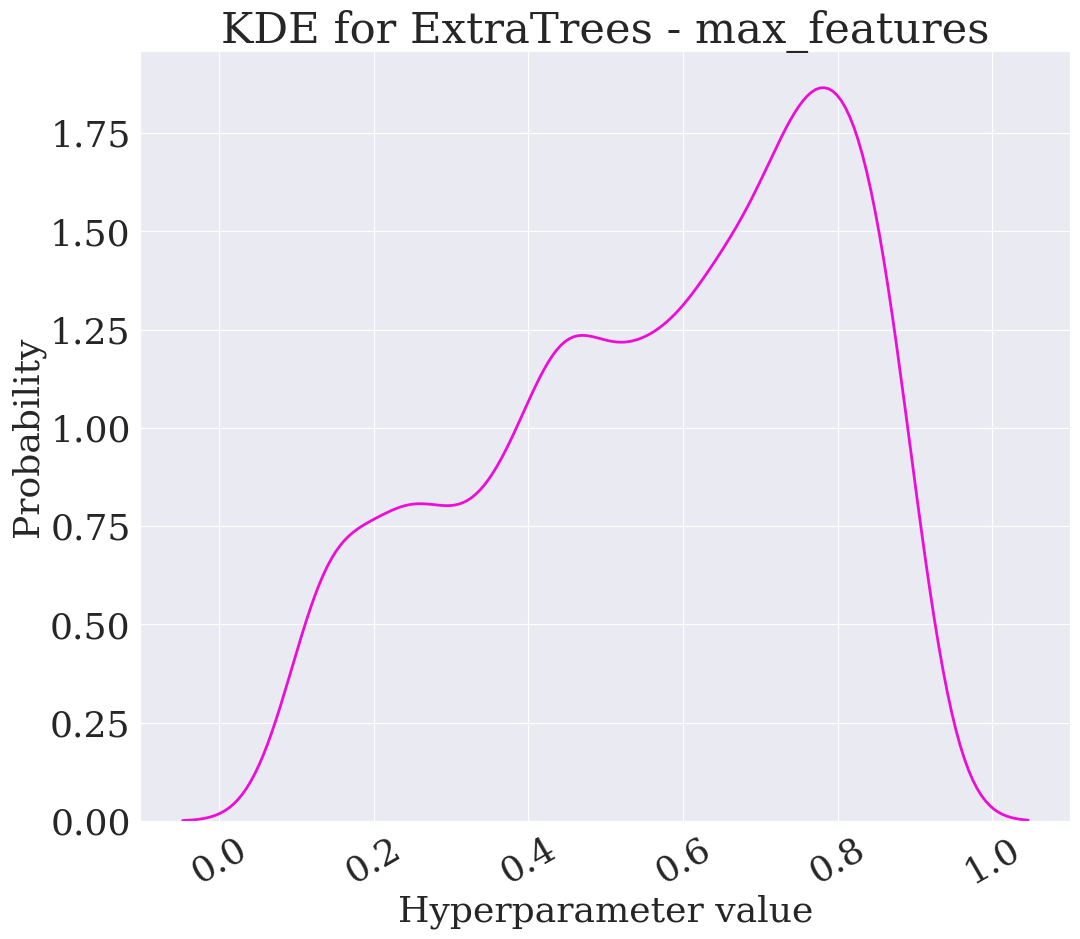

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cls_kde_plot(df, cls, important_hyperparameter):
    """
    Plot a KDE for recommending the best value for one hyperparameter.
    Input:
           df - DataFrame containing the results data
           cls - name of the classifier
           important_hyperparameter - the hyperparameter for which you're looking for the optimal default value
    Output:
           plt - it will show a plot on the output and also will save it as a PDF file
    """
    # No need to read the CSV file since we're passing the DataFrame directly
    # df = pd.read_csv(file_path)
    df_total = pd.DataFrame()

    for item in df.dataset.unique():

        df_dataset = df.loc[df['dataset'] == item]

        if df_dataset.empty:
            continue
        else:
            n = 10  # top 10 best dataset
            # find top 10 best auc across all different configuration for a specific dataset
            df_row = df_dataset.nlargest(n, 'CV_auc')

        ## Add those top 10 configurations to final DataFrame
        df_total = df_total.append(df_row)

    plt.figure(figsize=(12,10))

    # Ensure the important_hyperparameter exists in the DataFrame
    if important_hyperparameter in df_total.columns:
        sns.kdeplot(df_total[important_hyperparameter], legend=False, color="#ed0dd9", linewidth=2)
    else:
        print(f"Error: {important_hyperparameter} not found in the DataFrame columns.")
        return

    plt.xticks(rotation=30)
    plt.xlabel("Hyperparameter value")
    plt.ylabel("Probability")
    plt.title(f"KDE for {cls} - {important_hyperparameter}")  # Adding a title for clarity
    plt.savefig(f"./{cls}_{important_hyperparameter}.pdf", bbox_inches='tight', pad_inches=0, format='pdf')
    plt.show()  # This will display the plot in the notebook
    return

# Assuming df_et is already defined and contains the results data
# You would call the function like this, with "ExtraTrees" as the classifier name and the hyperparameter you're interested in.
cls_kde_plot(df_et, "ExtraTrees", "max_features")

# Share your thoughts and provide us feedback regarding to this notebook.(Optional)


## Write your feedback here:

# <font color='green'> Finished! </font>



